notebook for finding suteble $\mu$ and $\lambda$ for the greadien descent method

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import odl
from odl.contrib import torch as odl_torch
# from oppppppGet_Ray_Trafo import get_ray_trafo
from ray_transforms import get_ray_trafo
from util import hide_axis,Timer
#from data_set_functions_swaped import get_initial_dataset,append_dataset,get_adj_dataset,get_xis,get_x0s,defs_multiple_RTs, defs_list 
from test_model_functions_swaped import get_net_corected_operator
from scipy import sparse
from util import get_op,sparse_Mat,plots,error_for_y


c:\Users\Student\miniconda3\envs\PyTorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def im_norm(x):
    if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
        x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)
# Training    
pps = 64
x_res = pps
y_res = pps
n_ang = 256
n_dtp = 96#248
impl = 'astra_cpu'
static_ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,detector_len=2,impl=impl)


grad_R=None
shift_params =  (np.array([[[0.03,5000,0],[0.03,5000,0]]]))#np.load("shift_params/strong_u_v_shift.npy")#
# grad_R = odl.solvers.L2Norm(static_ray_trafo.domain).gradient
def get_shift(shift_params):
    def shift(angle):
        for i in range(shift_params.shape[0]):
            u_shift = shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift
def rand_shift(angle):
    u_shift = 0*angle+0.1*(np.random.rand()-0.5)
    v_shift = 0*angle+0.1*(np.random.rand()-0.5)

shift = get_shift(shift_params)
ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,DET_SHIFT = shift,detector_len=2,impl=impl)
# ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,shift_params=shift_params,detector_len=2,impl=impl)

A_s = sparse_Mat(ray_trafo,x_res,y_res,n_ang,n_dtp)
# A_s = sparse.load_npz('Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_0.npz')
true_op = get_op(A_s,x_res,y_res,n_ang,n_dtp)
ray_trafos=[true_op]

# A_static_s=sparse.load_npz('Matritzen/64_64_256_96_static.npz')
A_static_s = sparse_Mat(static_ray_trafo,x_res,y_res,n_ang,n_dtp)
static_op = get_op(A_static_s,x_res,y_res,n_ang,n_dtp)
op_norm2 = np.linalg.norm(A_static_s.todense(),2)**-2

# true_op = ray_trafo
# ray_trafos=[ray_trafo]
# static_op = static_ray_trafo
# op_norm2 = ray_trafo.norm('estimate')**2

  4%|▍         | 155/4096 [00:03<01:33, 42.15it/s]


KeyboardInterrupt: 

In [4]:
shift_params

array([[[  3.00000000e-02,   5.00000000e+03,   0.00000000e+00],
        [  3.00000000e-02,   5.00000000e+03,   0.00000000e+00]]])

In [5]:
# sparse.save_npz('64_64_256_96_2_u_v_shift.npz',A_s)
# sparse.save_npz('64_64_256_96_static.npz',A_static_s)

In [6]:
lam = 0.0001
mu = 0.0001
num_phant = 1
num_phant_rand = 0
e_p = 0.01
val_defs = defs_list()
tp = np.load('phantoms/'+f'test_phantoms_{pps}_1.npy')
# defs_multiple_RTs(val_defs, np.load('phantoms/'+f'validation_phantoms_{pps}_10.npy'), ray_trafos,
#                   static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))

defs_multiple_RTs(val_defs,tp, ray_trafos,
                  static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))


num_iterations = 20
# device = 'cuda'
# adj_swaped = True
# fw_swaped = True

NameError: name 'defs_list' is not defined

In [7]:
class ISTA():
    def __init__(self,mu,lam,y,fw_op,adj_op):
        self.mu = mu
        self.lam = lam
        self.y = y
        self.fw_op = fw_op
        self.adj_op = adj_op
    
    def soft_shrink(self,x,alpha): 
        return np.sign(x) * np.maximum(np.abs(x)-alpha,0)

    def get_impl(self,x):
        r = self.fw_op(x) - self.y
        F_abl = self.adj_op(r)
        if type(F_abl) is not np.ndarray:
            F_abl = F_abl.asarray()
        x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)
        # x = np.maximum(x,0)
        return x

In [8]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id] # error_for_y(p,0.1)
y_e = d[ye_id]
mu = 0.0004#0.0001#d[mu_id]
lam = 0.001#0.001 #d[lam_id]
x = x_0
op = true_op



lam = lam#/op_norm2
mu = min(mu,op_norm2)
ISTA_step = ISTA(mu,lam,y_e,op,op.adjoint).get_impl
ISTA_static_step = ISTA(mu,lam,y_e,static_op,static_op.adjoint).get_impl
x_odl = x_0

In [9]:
mu,lam

(0.0004, 0.001)

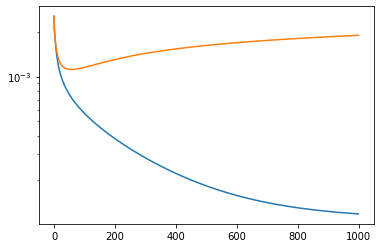

In [10]:
x = x_0
x_static = x_0
loss = list()
loss_static = list()
num_iter = 1000
for i in range(num_iter):
    x_old = x
    x = ISTA_step(x)
    x_static = ISTA_static_step(x_static)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)
    loss_static.append(np.linalg.norm((x_static-p).reshape(p.size))/p.size)
    # fig,ax =plt.subplots()
    # ax.imshow(x)
    # plt.show(fig)
    if im_norm(x-x_old)<10**-4:
        break

fig,ax =plt.subplots()
ax.plot(loss)
ax.plot(loss_static)
ax.set_yscale('log')
plt.show(fig)

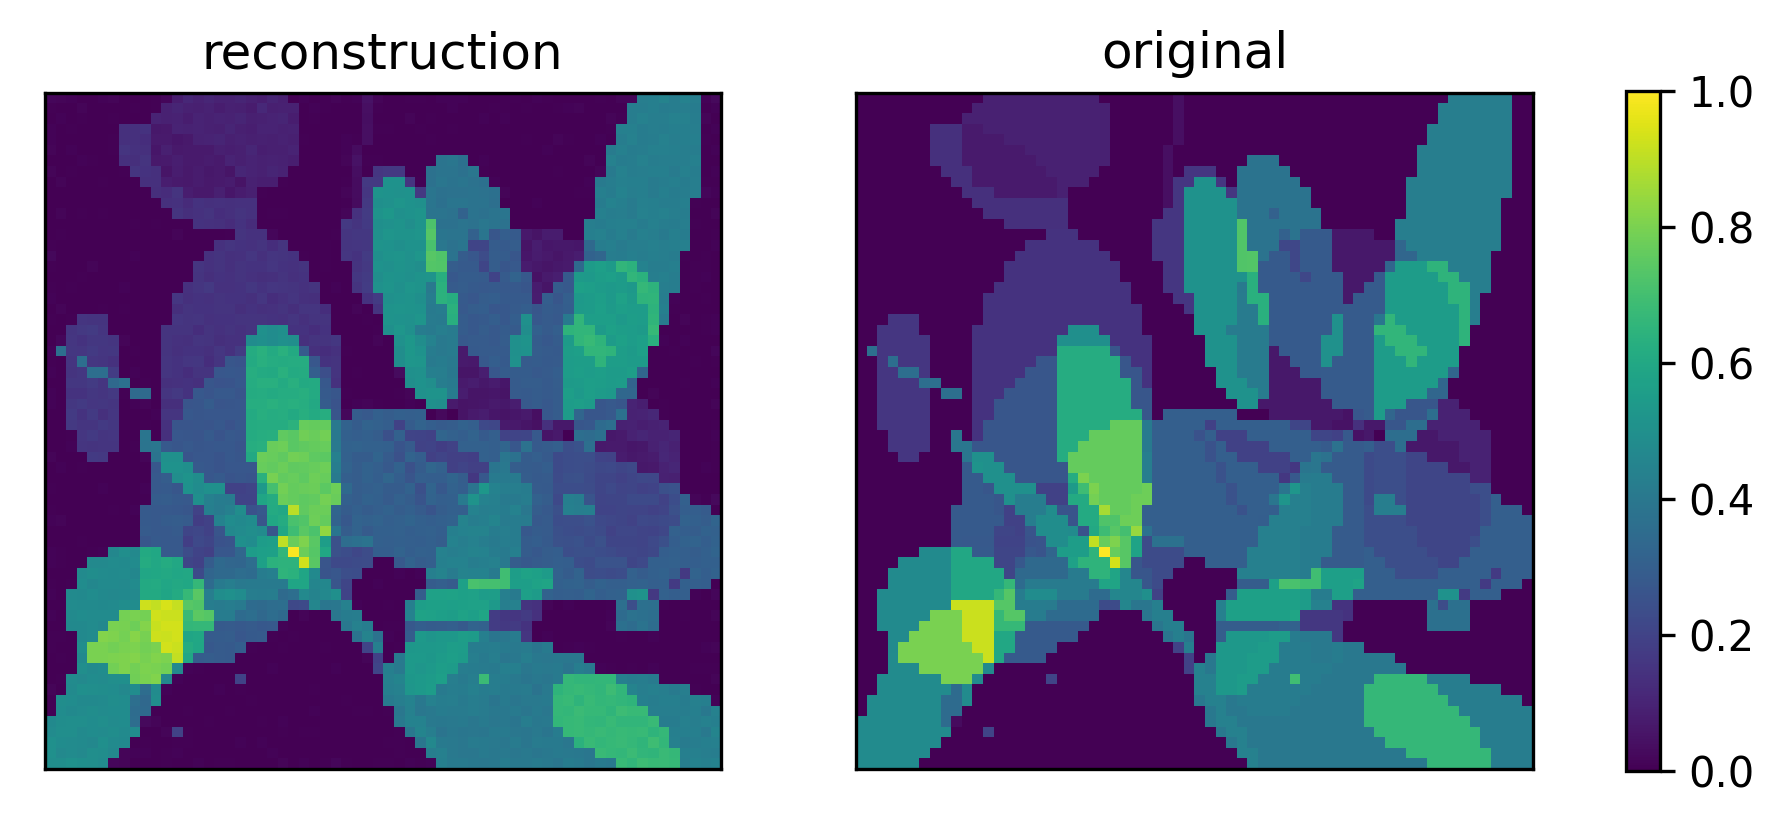

In [11]:
fig,ax = plots(1,2,4/3)
ax[0].imshow(x,vmin=0,vmax=1)
ax[0].set_title('reconstruction')
im = ax[1].imshow(p,vmin=0,vmax=1)  
ax[1].set_title('original')
fig.set_label = f'{num_iter} iterations,mu:{mu} lam:{lam}' 
hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

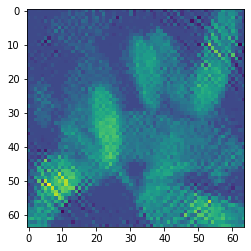

In [12]:
plt.imshow(x_static)

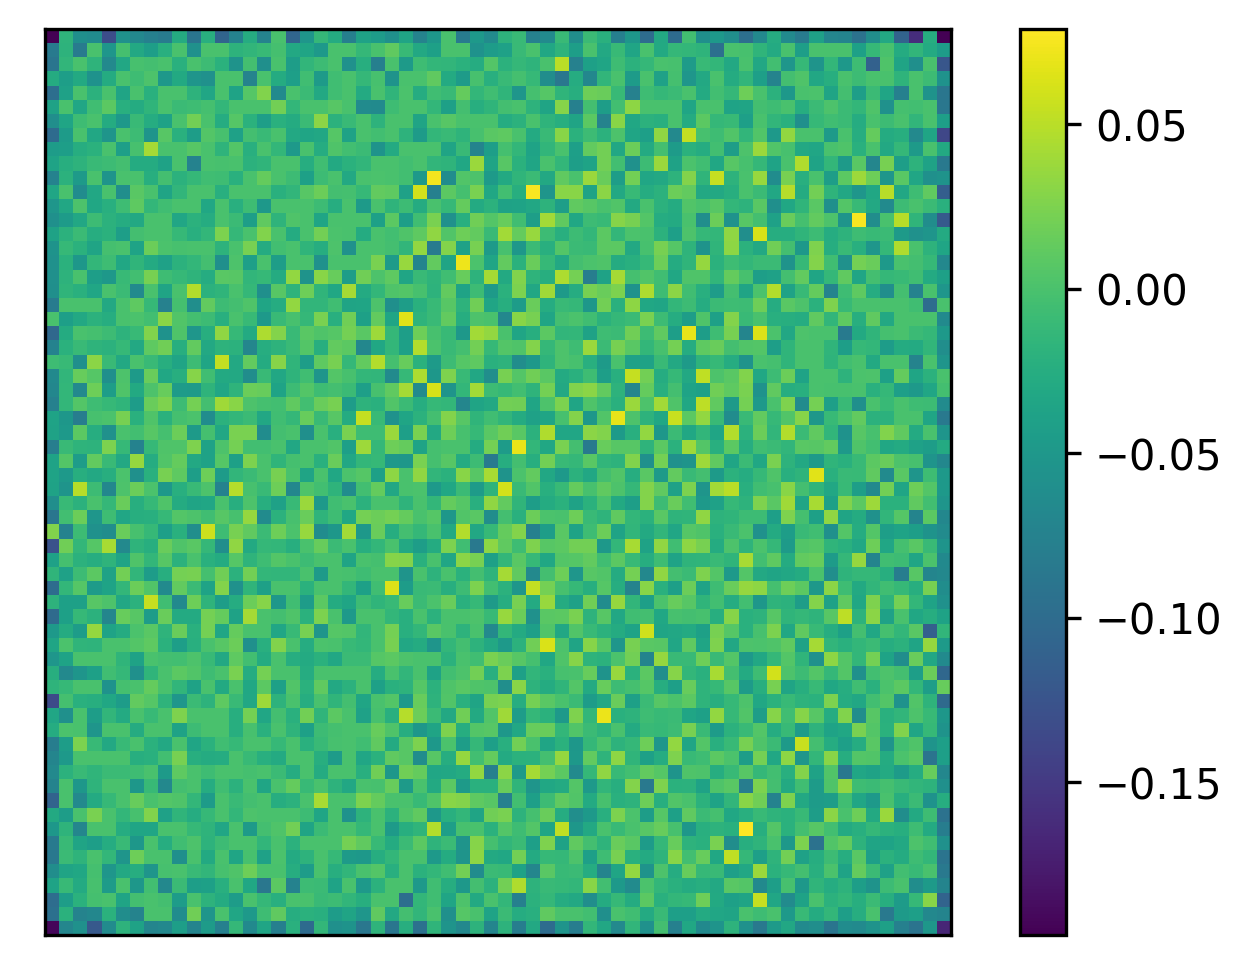

In [22]:
fig,ax = plt.subplots()
im = ax.imshow(p-x)          

hide_axis(fig)
fig.colorbar(im, ax=ax)

fig.set_dpi(300)
plt.show(fig)

In [74]:
op_norm2

0.49173115749737584

In [33]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
tracker = [np.inf,0,0]
op = static_op
num_iter = 500
j = 0
num_points = 20
loss_mat = np.zeros((num_points,num_points))
for mu in np.logspace(-3,-5,num_points):
        
        k = 0
        for lam in np.logspace(-2,-4,num_points):
                
                x = x_0
                lam = lam*op_norm2
                ISTA_step = ISTA(mu,lam,y_e,op,op.adjoint).get_impl
                for i in range(num_iter):
                        x = ISTA_step(x)
                loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
                loss_mat[j,k] = loss
                k = k+1
                if tracker[0]>loss:
                        tracker = [loss,mu,lam]
                        print(f'{100*j/num_points:0}% | {tracker}',end="\r")
        j = j+1
        print(f'{100*j/num_points:0}% | {tracker}',end="\r")


                

C:\Users\Student\AppData\Local\Temp\ipykernel_19736\441151023.py:17: RuntimeWarning: overflow encountered in multiply
  x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)
C:\Users\Student\AppData\Local\Temp\ipykernel_19736\441151023.py:17: RuntimeWarning: invalid value encountered in subtract
  x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)


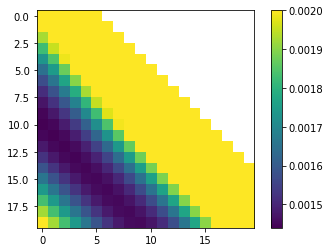

In [36]:
plt.imshow(loss_mat,vmax=0.002)
plt.colorbar()